<a href="https://colab.research.google.com/github/XHuang2046/Restaurant_Sales_Forecasting_by_ARIMA/blob/main/Restaurant_Sales_Forecasting_by_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # AutoCorrelation Plot, Partial AutoCorrelation Plot
from statsmodels.tsa.stattools import adfuller as ADF # Stationary Check
from statsmodels.stats.diagnostic import acorr_ljungbox # White noise check
import statsmodels.api as sm #D-W test, 1-st order autocorrelation test
from statsmodels.graphics.api import qqplot # QQ plot, nornal distribution test
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sales = pd.read_excel('/content/drive/MyDrive/resturant_data.xls',index_col='Date')
sales.head()

,Sales
Date,
2015-01-01,3023
2015-01-02,3039
2015-01-03,3056
2015-01-04,3138
2015-01-05,3188


In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2015-01-01 to 2015-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   37 non-null     int64
dtypes: int64(1)
memory usage: 592.0 bytes


In [3]:
sales.Sales = sales.Sales.astype('float')
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2015-01-01 to 2015-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   37 non-null     float64
dtypes: float64(1)
memory usage: 592.0 bytes


### Determining stationarity

**Time Plot**

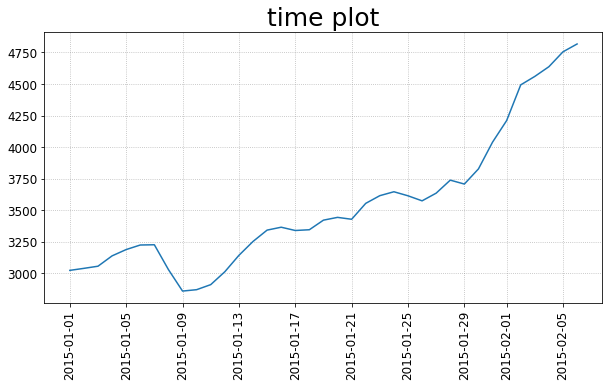

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
#sales.plot(kind='line',ax=ax)
ax.plot(sales)
ax.grid(ls=':', color='gray', alpha=0.6)

# set the axes
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# title 
ax.set_title('time plot', fontsize=25)

plt.show()

**Auto Correlation Plot**

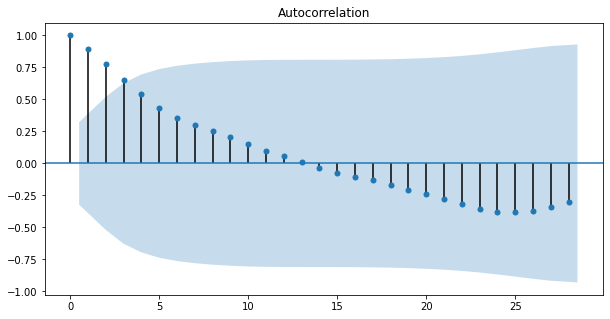

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(sales,lags=28,ax=ax)
plt.show()

**ADF Test**

In [17]:
result = ADF(sales.Sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values in different significance levels:')
for key, value in result[4].items():
	print('\t%s: %.4f' % (key, value))

# P > 0.05, so we accept the null hypothesis that there is a unit root, which means that the sequence is non-stationary.

ADF Statistic: 1.813771
p-value: 0.998376
Critical Values in different significance levels:
	1%: -3.7112
	5%: -2.9812
	10%: -2.6301


### Testing First Differenced Time Seires

Since the time series is a non-stationary sequence, we need to create the first differenced time series and re-do the stationarity check on it.

In [5]:
d1_sales=sales.diff(periods=1, axis=0).fillna(0)
d1_sales.head()

,Sales
Date,
2015-01-01,0.0
2015-01-02,16.0
2015-01-03,17.0
2015-01-04,82.0
2015-01-05,50.0


**Time plot**

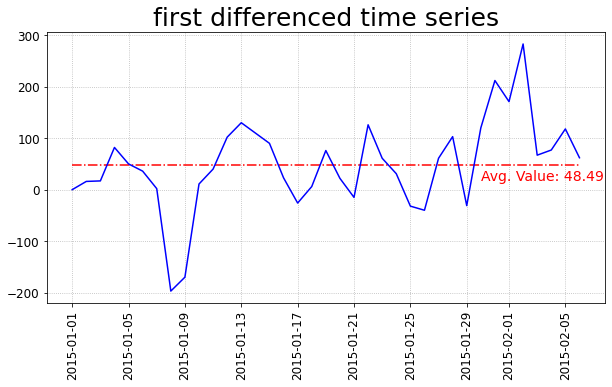

In [5]:
# define the data for plotting
x = d1_sales.index
y = d1_sales.Sales

# set the color
color1 = 'b'
color2 = 'r'

# set the figure size
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the first differencing line chart
ax.plot(x, y, color=color1)

# plot the average line
ax.hlines(y.mean(), x[0], x[-1:], linestyles='-.', colors=color2)
ax.text(x[-8], y.mean()-30, 'Avg. Value: ' + str(round(y.mean(),2)),
        color=color2, fontsize=14)

# set the grid
ax.grid(ls=':', color='gray', alpha=0.6)
# set the axes
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
# title 
ax.set_title('first differenced time series', fontsize=25)

plt.show()

The first differencing is relatively stationary as it varies around the mean value.

**ACF Plot**

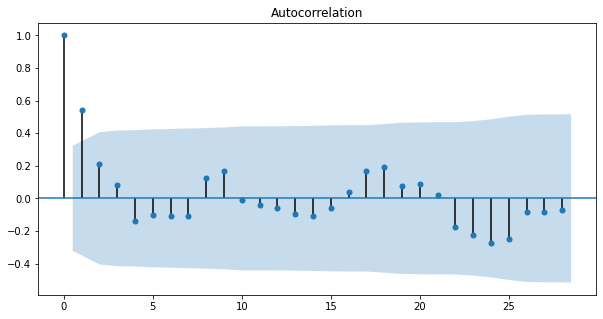

In [9]:
# AutoCorrelation Plot
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(d1_sales,lags=28,ax=ax).show()
# The ac value converge towards 0.
# It has short-range independence.

**Stationarity Check**

In [6]:
res_1 = ADF(d1_sales.Sales)
print('ADF Statistic: %f' % res_1[0])
print('p-value: %f' % res_1[1])
print('Critical Values in different significance levels:')
for key, value in res_1[4].items():
	print('\t%s: %.4f' % (key, value))

# P < 0.05, so we accept the alternative hypothesis that there is no unit root
# First differenced sequence is stationary.

ADF Statistic: -3.206873
p-value: 0.019590
Critical Values in different significance levels:
	1%: -3.6267
	5%: -2.9460
	10%: -2.6117


**White Noise Check**


In [37]:
print('The P-value for white noise check is:',acorr_ljungbox(d1_sales,lags=1)[1][0])

# P < 0.05，so we reject the null hypothesis.
# First differencing is not white noise.

The P-value for white noise check is: 0.0006425352363886988


### Select the Parameters

Plotting ACF and PACF to estimate the parameters for the ARIMA model

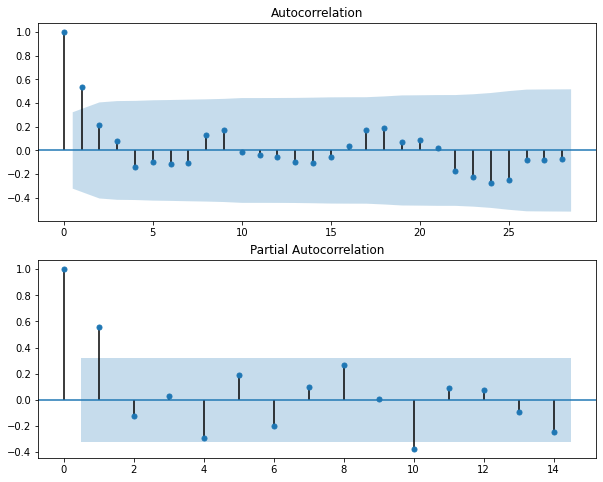

In [11]:
fig = plt.figure(figsize=(10,8))
# plot ACF 
ax1=plt.subplot(211)
plot_acf(d1_sales,lags=28,ax=ax1)
# Plot PACF
ax2=plt.subplot(212)
plot_pacf(d1_sales,lags=14,ax=ax2)

plt.show()


The ACF cuts off after 1st lag.  
The PACF tails off after 1st lag.  
So ARIMA(p,d,q) = ARIMA(0,1,1)  

**Select the parameters based on AIC/BIC**

In [18]:
pmax=int(len(d1_sales)/10) 
qmax=int(len(d1_sales)/10) 
pmax

3

In [ ]:
# Based on BIC

bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sales,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)


In [26]:
bic_matrix=pd.DataFrame(bic_matrix)
bic_matrix

,0,1,2,3
0,432.068472,422.510082,426.088911,426.595507
1,423.628276,426.073601,NaN,NaN
2,426.774824,427.395799,431.003529,NaN
3,430.317524,431.924814,434.761733,436.478109


In [27]:
bic_matrix.stack()

0  0    432.068472
   1    422.510082
   2    426.088911
   3    426.595507
1  0    423.628276
   1    426.073601
2  0    426.774824
   1    427.395799
   2    431.003529
3  0    430.317524
   1    431.924814
   2    434.761733
   3    436.478109
dtype: float64

In [31]:
p,q=bic_matrix.stack().idxmin() # index for the min value
print('Based on BIC, the best (p, q) is', (p,q))

Based on BIC, the best (p, q) is (0, 1)


In [ ]:
# Based on AIC

aic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(sales,(p,1,q)).fit().aic)
        except:
            tmp.append(None)
    aic_matrix.append(tmp)

In [35]:
aic_matrix

,0,1,2,3
0,428.901435,417.759525,419.754835,418.677913
1,418.877719,419.739526,NaN,NaN
2,420.440748,419.478204,421.502415,NaN
3,422.399930,422.423701,423.677100,423.809958


In [34]:
aic_matrix=pd.DataFrame(aic_matrix)
p,q=aic_matrix.stack().idxmin()
print('Based on AIC, the best (p, q) is', (p,q))

Based on AIC, the best (p, q) is (0, 1)


So the best parameters for the ARIMA model is (0,1,1)

### Building ARIMA Model and Predicting

In [7]:
# Modeling 
model=ARIMA(sales,(0,1,1)).fit()


In [13]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   36
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -205.880
Method:                       css-mle   S.D. of innovations             73.086
Date:                Wed, 21 Jul 2021   AIC                            417.760
Time:                        15:29:06   BIC                            422.510
Sample:                    01-02-2015   HQIC                           419.418
                         - 02-06-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.9557     20.139      2.481      0.018      10.484      89.427
ma.L1.D.Sales     0.6710      0.165      4.071      0.000       0.348       0.994
                                    Root

**Residual Diagonstics**

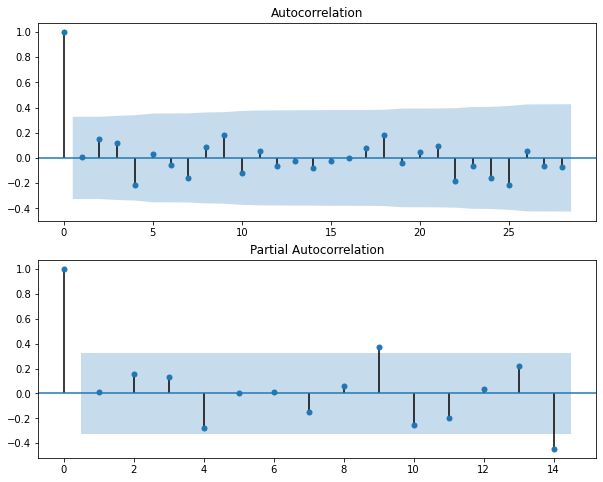

In [8]:
resid=model.resid

fig = plt.figure(figsize=(10,8))
# plot ACF 
ax1=plt.subplot(211)
plot_acf(resid,lags=28,ax=ax1)
# Plot PACF
ax2=plt.subplot(212)
plot_pacf(resid,lags=14,ax=ax2)

plt.show()

QQ Plot

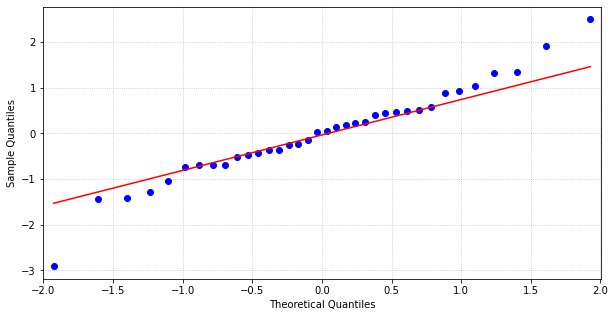

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
qqplot(resid, line='q', fit=True, ax=ax)
ax.grid(ls=':', color='gray', alpha=0.5)
plt.show()
# Residual error is normal distributed, with 0 mean and constant variance.

In [36]:
a = acorr_ljungbox(resid,lags=1)
print('The test statistic is %.4f, the p-value is %.4f'%(a[0][0],a[1][0]))

The test statistic is 0.0039, the p-value is 0.9502


P > 0.05, so we accpet the null hypothesis that the residual is white noise. 

**Forecasting the following 7 days sales revenue**

In [10]:
forecast = model.forecast(7)

In [28]:
fore_y = forecast[0]
fore_ci = forecast[2]

In [17]:
df_fore=pd.Series(fore_y,index=pd.date_range('2015-2-7',periods=7,freq='D'))
df_fore

2015-02-07    4873.966548
2015-02-08    4923.922616
2015-02-09    4973.878685
2015-02-10    5023.834753
2015-02-11    5073.790822
2015-02-12    5123.746890
2015-02-13    5173.702959
Freq: D, dtype: float64

In [29]:
fore_ci

array([[4730.72112437, 5017.21197102],
       [4644.96720157, 5202.87803086],
       [4606.3014882 , 5341.45588128],
       [4585.18926146, 5462.48024505],
       [4574.0841683 , 5573.49747526],
       [4569.66782411, 5677.82595649],
       [4570.12986163, 5777.276056  ]])

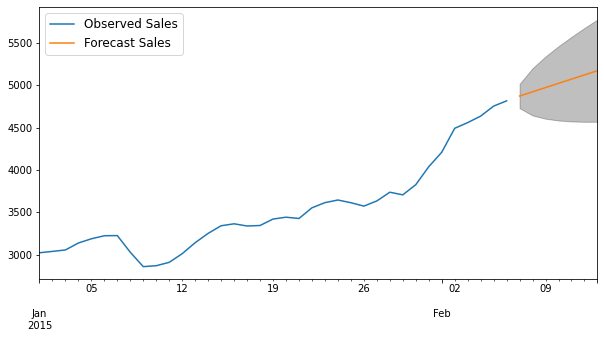

In [41]:
data=pd.concat((sales,df_fore),axis=0)
data.columns=['Observed Sales','Forecast Sales']
x = df_fore.index
y1 = [i[0] for i in fore_ci] # The lower bound of confidence interval
y2= [i[1] for i in fore_ci] # The upper bound of Confidence Interval
fig,ax = plt.subplots(figsize=(10,5))
data.plot(ax=ax)
ax.fill_between(x, y1,y2, where = (y2>y1),color='k', alpha=.25)
ax.legend(loc='upper left', fontsize=12)
plt.show();